### CNN

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import cv2
import os
import time
import shutil
import random

from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2

In [2]:
dataset_path = 'D:/Nexmedis Recruitment/Problem 2/chest_xray'
sets = ['train', 'test', 'val']
pneumonia_folder = 'PNEUMONIA'
pneu_label = ['Viral Pneumonia', 'Barterial Pneumonia']

In [3]:
for set in sets:
    path = os.path.join(dataset_path, set)
    pneumonia_path = os.path.join(path, pneumonia_folder)

    if not os.path.exists(pneumonia_path):
        continue

    for label_folder in pneu_label:
        target_path = os.path.join(path, label_folder)
        os.makedirs(target_path, exist_ok=True)

    for filename in os.listdir(pneumonia_path):
        img_file = os.path.join(pneumonia_path, filename)
        if "bacteria" in filename.lower():
            dst_folder = pneu_label[1]
            dst_file = os.path.join(path, dst_folder, filename)
            shutil.move(img_file, dst_file)
        elif "virus" in filename.lower():
            dst_folder = pneu_label[0]
            dst_file = os.path.join(path, dst_folder, filename)
            shutil.move(img_file, dst_file)
        else:
            continue

    if not os.listdir(pneumonia_path):
        os.rmdir(pneumonia_path)


In [4]:
class_names = tf.io.gfile.listdir(dataset_path +'/train')
print(class_names)

['Barterial Pneumonia', 'NORMAL', 'Viral Pneumonia']


In [5]:
IMG_SIZE = (128, 128)

def get_data(data_dir):
    data = []
    for label in class_names:
        path = os.path.join(data_dir, label)
        lab = class_names.index(label)
        for filename in os.listdir(path):
            try: 
                img = cv2.imread(os.path.join(path, filename), 0)
                resize = cv2.resize(img, IMG_SIZE)
                data.append([resize, lab])
            except Exception as e:
                print(e)
    return data

In [6]:
train = get_data(os.path.join(dataset_path, "train"))
test = get_data(os.path.join(dataset_path, "test"))

In [9]:
train[2][0]

array([[ 0,  0,  2, ..., 30, 22, 34],
       [ 0,  0,  8, ..., 64, 20, 26],
       [ 0,  5, 16, ..., 73, 58, 17],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

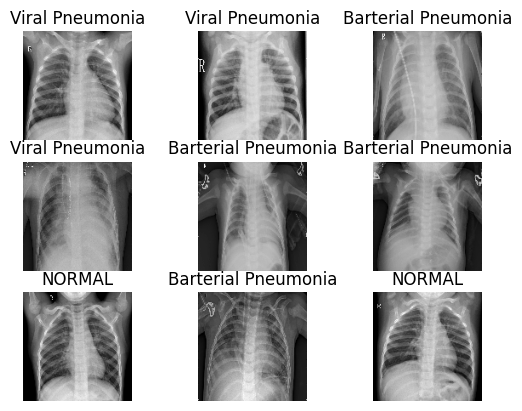

In [10]:
for i in range(9):
   index = random.randint(0, len(train)-1)
   image = train[index][0]
   label = class_names[train[index][1]]
   plt.subplot(3,3,i+1)
   plt.imshow(image, cmap='gray')
   plt.title(label)
   plt.axis('off')   

In [7]:
X_train = []
y_train = []
X_test = []
y_test = []

for img, label in train: 
    X_train.append(img)
    y_train.append(label)

for img, label in test: 
    X_test.append(img)
    y_test.append(label)

In [12]:
X_train[0]

array([[19, 27, 30, ..., 16,  9,  2],
       [24, 26, 34, ..., 17, 11,  4],
       [22, 30, 39, ..., 19, 11,  4],
       ...,
       [10,  8,  7, ..., 15, 15, 15],
       [10,  8,  7, ..., 15, 15, 15],
       [10, 10,  7, ..., 15, 15, 15]], dtype=uint8)

In [13]:
y_train[0]

0

In [8]:
X_train = np.array(X_train).reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)
X_test = np.array(X_test).reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)

In [9]:
X_train = np.array(X_train) /255.0
y_train = to_categorical(y_train, num_classes=3)

X_test = np.array(X_test) /255.0
y_test = to_categorical(y_test, num_classes=3)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, 
    random_state=42, stratify=y_train)

In [11]:
train_aug = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
)
val_aug = ImageDataGenerator()

train_gen = train_aug.flow(X_train, y_train, batch_size=32, shuffle=True)
val_gen = val_aug.flow(X_val, y_val, batch_size=32)

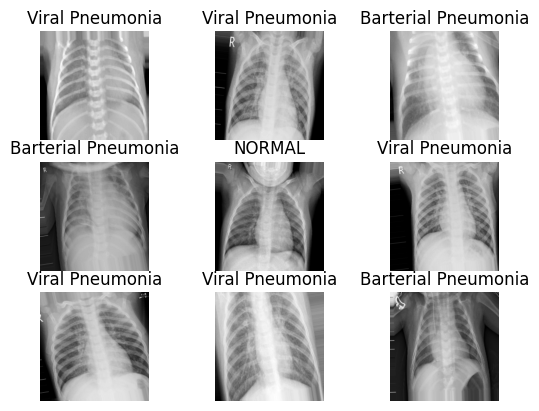

In [16]:
aug_data = train_aug.flow(X_train, y_train, batch_size=9, shuffle=True)

images, labels = next(aug_data)

for i in range(9):
    image = images[i].reshape(images[i].shape[0], images[i].shape[1])
    label = class_names[labels[i].argmax()]
    plt.subplot(3, 3, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(label)
    plt.axis('off')

In [16]:
print('Train data: ', len(X_train))
print('Val data: ', len(X_val))
print('Test data: ', len(X_test))

Train data:  4172
Val data:  1044
Test data:  624


In [17]:
labels = np.argmax(y_train, axis=1)
unique, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"{class_names[label]}: {count} samples")

Barterial Pneumonia: 2024 samples
NORMAL: 1072 samples
Viral Pneumonia: 1076 samples


In [27]:
model = Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(*IMG_SIZE, 1)),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(3, activation='softmax')
])

d:\Python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
model.summary()
# 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,371 (14.14 MB)

 Trainable params: 3,706,371 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
start = time.time()
history = model.fit(train_gen,
                    epochs=100,
                    validation_data = val_gen)
end = time.time()
print('Time needed : ', str(end-start))

d:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.4815 - loss: 1.0602 - val_accuracy: 0.6485 - val_loss: 0.7965
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 165ms/step - accuracy: 0.6620 - loss: 0.7835 - val_accuracy: 0.7375 - val_loss: 0.6202
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.7070 - loss: 0.6831 - val_accuracy: 0.7567 - val_loss: 0.5704
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.7087 - loss: 0.6669 - val_accuracy: 0.7529 - val_loss: 0.5818
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.7462 - loss: 0.6040 - val_accuracy: 0.7672 - val_loss: 0.5800
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 166ms/step - accuracy: 0.7451 - loss: 0.6079 - val_accuracy: 0.7529 - val_loss: 0.5941
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/step - accuracy: 0.7500 - loss: 0.5953 - val_accuracy: 0.7720 - val_loss: 0.5385
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.7515 -

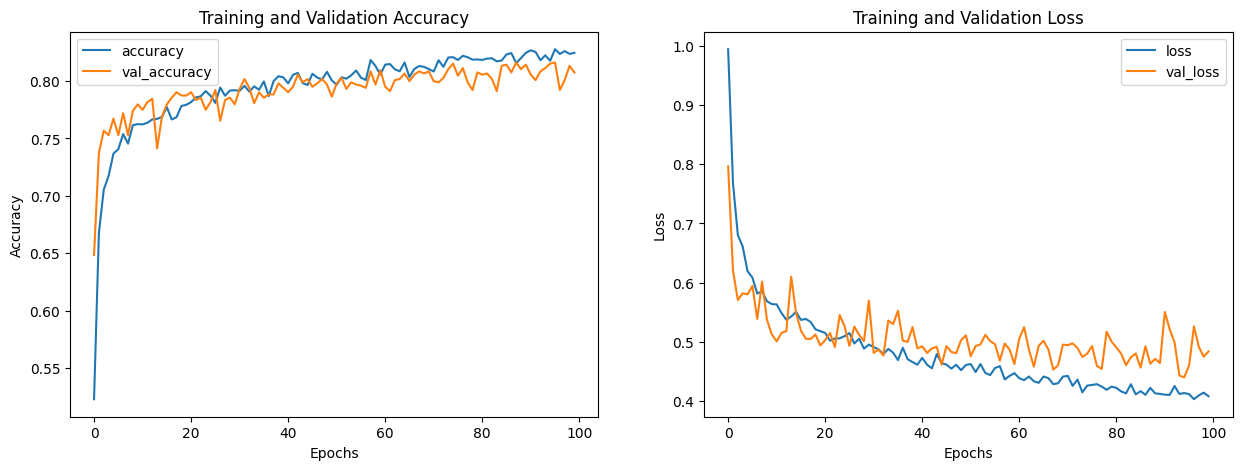

In [21]:
metrics = history.history
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [22]:
loss, acc = model.evaluate(X_test, y_test,  batch_size=32)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9080 - loss: 0.4100
Test Loss: 0.6193
Test Accuracy: 0.8413


In [23]:
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
                     precision    recall  f1-score   support

Barterial Pneumonia     0.8493    0.9545    0.8988       242
             NORMAL     0.9667    0.7436    0.8406       234
    Viral Pneumonia     0.6977    0.8108    0.7500       148

           accuracy                         0.8413       624
          macro avg     0.8379    0.8363    0.8298       624
       weighted avg     0.8573    0.8413    0.8417       624



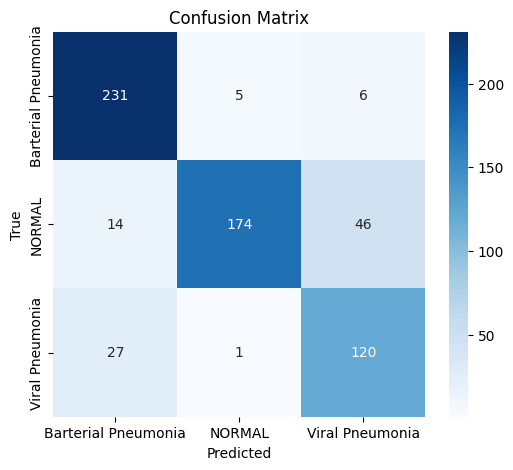

In [24]:
cm = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [25]:
model.save('medical_imaging_CNN.h5')

### MobileNet

In [18]:
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train_rgb])
X_val_resized = np.array([cv2.resize(img, (224, 224)) for img in X_val_rgb])
X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test_rgb])

train_gen2 = train_aug.flow(X_train_resized, y_train, batch_size=32, shuffle=True)
val_gen2 = val_aug.flow(X_val_resized, y_val, batch_size=32)

In [19]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model_mobilenet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(3, activation='softmax')
])

In [20]:
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model_mobilenet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [22]:
start = time.time()
history_mobilenet = model_mobilenet.fit(train_gen2,
                    epochs=50,
                    validation_data = val_gen2)
end = time.time()
print('Time needed : ', str(end-start))

d:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 616ms/step - accuracy: 0.6089 - loss: 0.8388 - val_accuracy: 0.7462 - val_loss: 0.6010
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 73s 559ms/step - accuracy: 0.7473 - loss: 0.5830 - val_accuracy: 0.7615 - val_loss: 0.5499
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 76s 576ms/step - accuracy: 0.7705 - loss: 0.5526 - val_accuracy: 0.7481 - val_loss: 0.5559
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 76s 583ms/step - accuracy: 0.7783 - loss: 0.5301 - val_accuracy: 0.7711 - val_loss: 0.5220
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 77s 584ms/step - accuracy: 0.7812 - loss: 0.5135 - val_accuracy: 0.7586 - val_loss: 0.5690
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 75s 573ms/step - accuracy: 0.7890 - loss: 0.5043 - val_accuracy: 0.7739 - val_loss: 0.5284
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 76s 581ms/step - accuracy: 0.7852 - loss: 0.4869 - val_accuracy: 0.7768 - val_loss: 0.5227
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 75s 571ms/step - accuracy: 0.8004 - loss: 0

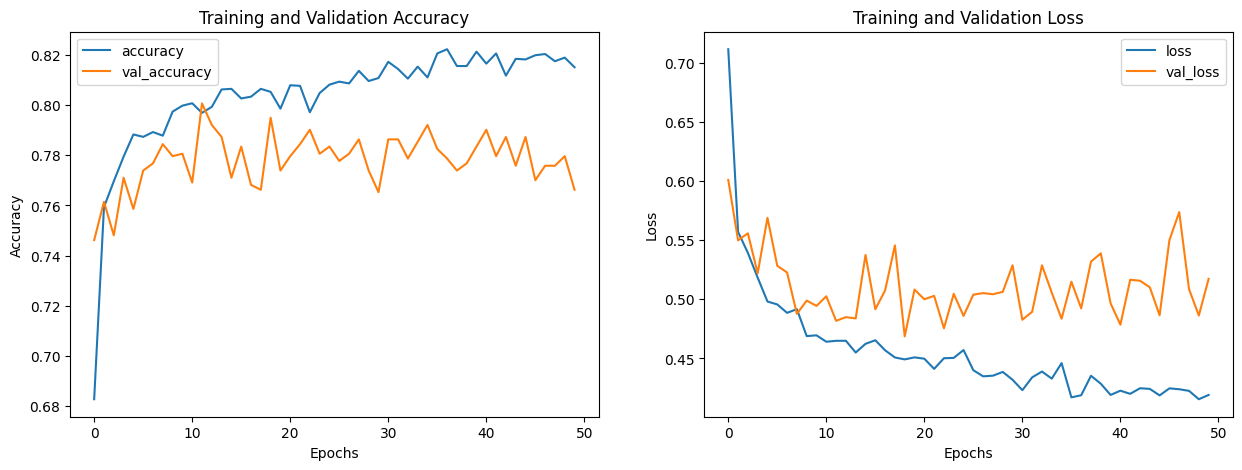

In [23]:
metrics = history_mobilenet.history
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [24]:
loss, acc = model_mobilenet.evaluate(X_test_resized, y_test,  batch_size=32)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step - accuracy: 0.8984 - loss: 0.3770
Test Loss: 0.5045
Test Accuracy: 0.8446


In [25]:
preds = model_mobilenet.predict(X_test_resized)
y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 286ms/step
                     precision    recall  f1-score   support

Barterial Pneumonia     0.8152    0.9298    0.8687       242
             NORMAL     0.9406    0.8120    0.8716       234
    Viral Pneumonia     0.7671    0.7568    0.7619       148

           accuracy                         0.8446       624
          macro avg     0.8410    0.8328    0.8341       624
       weighted avg     0.8508    0.8446    0.8445       624



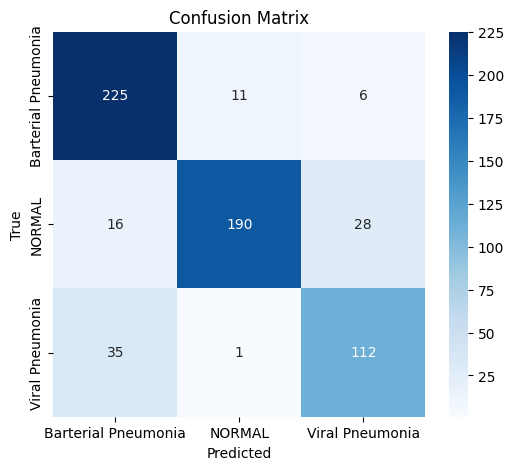

In [26]:
cm = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Epoch Variation

#### 25 Epoch

In [12]:
model_25 = Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(*IMG_SIZE, 1)),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(3, activation='softmax')
])

d:\Python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_25.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
model_25.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,371 (14.14 MB)

 Trainable params: 3,706,371 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
start = time.time()
history_25 = model_25.fit(train_gen,
                    epochs=25,
                    validation_data = val_gen)
end = time.time()
print('Time needed : ', str(end-start))

Epoch 1/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - accuracy: 0.4988 - loss: 1.0305 - val_accuracy: 0.5939 - val_loss: 0.8977
Epoch 2/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.5496 - loss: 0.9290 - val_accuracy: 0.6533 - val_loss: 0.7981
Epoch 3/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 0.6673 - loss: 0.7630 - val_accuracy: 0.6964 - val_loss: 0.6797
Epoch 4/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.6927 - loss: 0.7205 - val_accuracy: 0.7423 - val_loss: 0.6206
Epoch 5/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.7029 - loss: 0.6923 - val_accuracy: 0.7481 - val_loss: 0.5877
Epoch 6/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.6961 - loss: 0.7007 - val_accuracy: 0.7433 - val_loss: 0.5982
Epoch 7/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.7059 - loss: 0.6823 - val_accuracy: 0.7557 - val_loss: 0.5509
Epoch 8/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 0.7152 - loss: 0

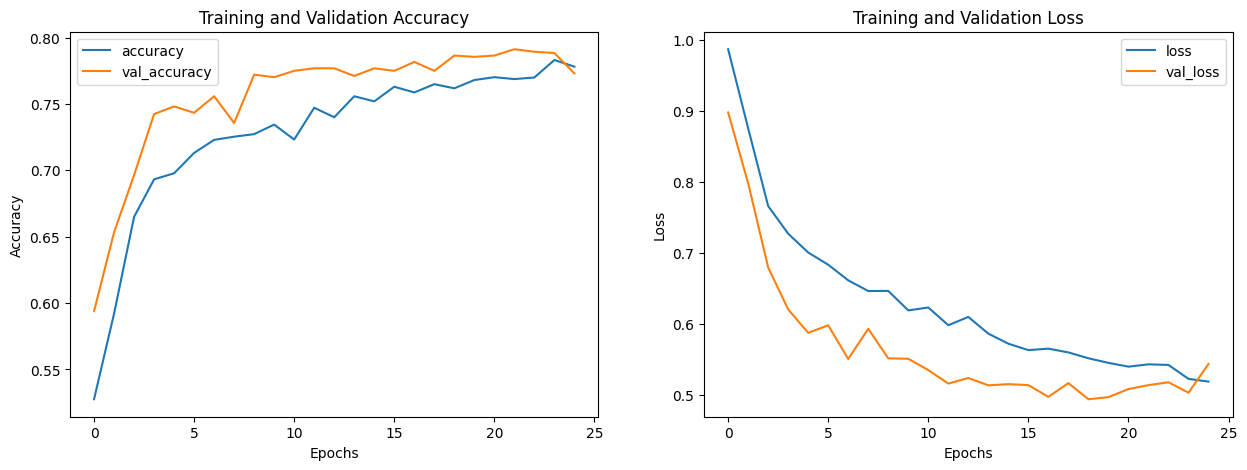

In [16]:
metrics = history_25.history
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history_25.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_25.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [17]:
loss, acc = model_25.evaluate(X_test, y_test,  batch_size=32)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8881 - loss: 0.4522
Test Loss: 0.6727
Test Accuracy: 0.8253


In [18]:
preds = model_25.predict(X_test)
y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
                     precision    recall  f1-score   support

Barterial Pneumonia     0.8225    0.9380    0.8764       242
             NORMAL     0.9362    0.7521    0.8341       234
    Viral Pneumonia     0.7000    0.7568    0.7273       148

           accuracy                         0.8253       624
          macro avg     0.8195    0.8156    0.8126       624
       weighted avg     0.8361    0.8253    0.8252       624



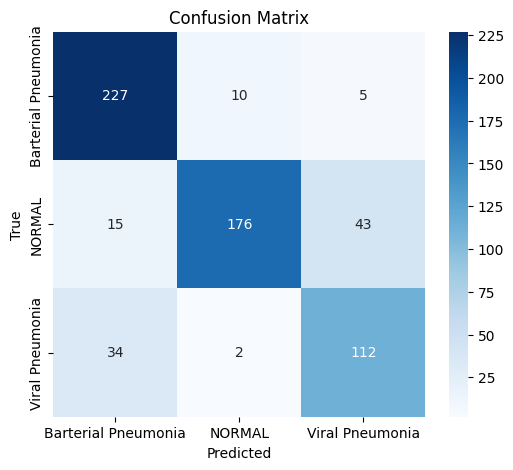

In [19]:
cm = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#### 50 Epochs

In [20]:
model_50 = Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(*IMG_SIZE, 1)),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(3, activation='softmax')
])

d:\Python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_50.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
model_50.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,371 (14.14 MB)

 Trainable params: 3,706,371 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
start = time.time()
history_50 = model_50.fit(train_gen,
                    epochs=50,
                    validation_data = val_gen)
end = time.time()
print('Time needed : ', str(end-start))

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.4566 - loss: 1.0931 - val_accuracy: 0.5920 - val_loss: 0.8725
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.6359 - loss: 0.8163 - val_accuracy: 0.6973 - val_loss: 0.6921
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.6683 - loss: 0.7546 - val_accuracy: 0.7213 - val_loss: 0.6237
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 0.6916 - loss: 0.7102 - val_accuracy: 0.7404 - val_loss: 0.6003
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.7012 - loss: 0.7003 - val_accuracy: 0.7203 - val_loss: 0.6344
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 138ms/step - accuracy: 0.7004 - loss: 0.6990 - val_accuracy: 0.7510 - val_loss: 0.5614
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - accuracy: 0.7134 - loss: 0.6464 - val_accuracy: 0.7625 - val_loss: 0.5415
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.7352 - loss: 0

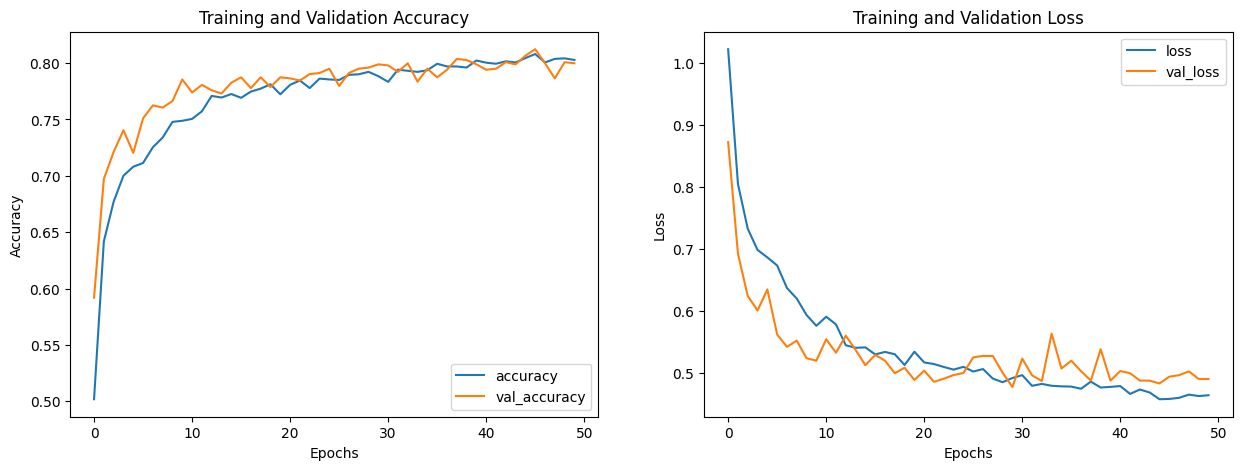

In [23]:
metrics = history_50.history
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history_50.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_50.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [24]:
loss, acc = model_50.evaluate(X_test, y_test,  batch_size=32)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9046 - loss: 0.4426
Test Loss: 0.7358
Test Accuracy: 0.8141


In [25]:
preds = model_50.predict(X_test)
y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
                     precision    recall  f1-score   support

Barterial Pneumonia     0.8201    0.9793    0.8927       242
             NORMAL     0.9808    0.6538    0.7846       234
    Viral Pneumonia     0.6592    0.7973    0.7217       148

           accuracy                         0.8141       624
          macro avg     0.8200    0.8102    0.7997       624
       weighted avg     0.8422    0.8141    0.8116       624



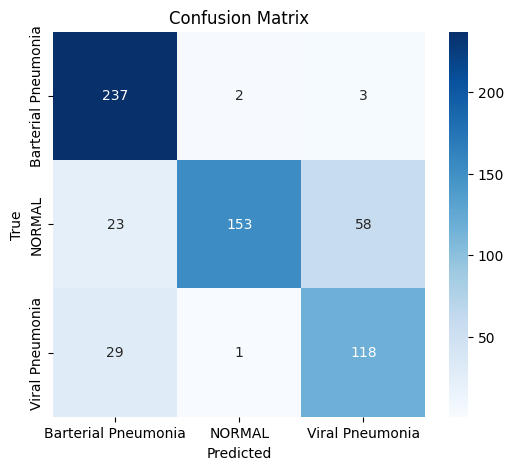

In [26]:
cm = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()